# PyTorch Baseline Model

## Creating a virtual environment for the project (Windows)

### Creating a virtual environment
The following command creates a virtual environment in the current directory.

The name of the virtual environment is .venv.

Remember to ensure that the kernel is set to the virtual environment.

```powershell
python -m venv .venv
```

### Activating the virtual environment
The following command activates the virtual environment.

```powershell
.\.venv\Scripts\Activate.ps1
```

### Deactivating the virtual environment
The following command deactivates the virtual environment.

```powershell
deactivate
```

### Installing packages
The following command installs the packages listed in requirements.txt.

```powershell
pip install -r requirements.txt
```

### Updating requirements.txt
The following command updates requirements.txt with the packages installed in the virtual environment.

```powershell
pip freeze > requirements.txt
```

### Appending additional index URL to requirements.txt

```
-i https://download.pytorch.org/whl/nightly/cu121
```

# Imports

In [25]:
import torch # PyTorch
import torchvision # PyTorch Vision

# Global Variables

In [26]:
# Define the device to be used for training the model (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the path of the dataset
dataset_root_path = "./frames/"

# Define the folders of the dataset
dataset_folders = ["test", "train"]

# Define the categories of the dataset
classification_categories = ["norm", "weap"]  # 0 = norm, 1 = weap

# Define the dimensions of the images
image_dimensions = (224, 224)

# Define batch size
batch_size = 64
import math
grid_row_length = math.ceil(math.sqrt(batch_size))

# Define the number of epochs
epochs = 2

# Define model name
model_name = "pytorch_baseline_model.pth"

# Printing Environment Information

In [27]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("Device Count: ",torch.cuda.device_count())
print("Device: ",torch.cuda.get_device_name(0))
print("CUDA Available: ",torch.cuda.is_available())
print("Current CUDA Device Name: ",torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch Version:  2.2.0.dev20231101+cu121
Torchvision Version:  0.17.0.dev20231101+cu121
Device Count:  1
Device:  NVIDIA GeForce RTX 4090
CUDA Available:  True
Current CUDA Device Name:  NVIDIA GeForce RTX 4090


# Train on GPU if available

In [28]:
# Additional Info when using cuda
if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))
  print('Memory Usage:')
  print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
  print('Reserved:', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

NVIDIA GeForce RTX 4090
Memory Usage:
Allocated: 5.5 GB
Reserved: 6.4 GB


# Label Creation

In [29]:
'''
This cell will attempt to create a csv file containing mappings of the image
file names along with a numerical label where 0 is norm and 1 is weap.
E.g.: "norm/0000_120.png,0"
E.g.: "weap/0200778_20220903_threat_8396_180.png,1"
'''

import os  # For file path operations
import pandas as pd  # For data manipulation

# Loop through the folders and categories
for folder in dataset_folders:
  temp_list = []
  for category in classification_categories:
    # Initialize an empty list to store the data

    # Loop through the images of the category
    image_dir = os.path.join(dataset_root_path, folder, category)
    for image in os.listdir(image_dir):
      # Append the image name and the category to the data list
      label = 0 if category == "norm" else 1
      temp_list.append((os.path.join(category, image), label))

  # Create a Pandas DataFrame from the data list
  df = pd.DataFrame(temp_list, columns=["image", "label"])

  # Save the DataFrame to a CSV file
  df.to_csv(f"{folder}_labels.csv", index=False)

# Custom DataLoader

In [30]:
'''
This cell will attempt to create a custom PyTorch dataset class that will
load the images and labels from the CSV file.
'''

from torch.utils.data import Dataset  # For custom datasets
from torchvision.io import read_image  # For reading images

class CustomImageDataset(Dataset):
  # https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform 
    self.target_transform = target_transform

  def __len__(self) -> int:
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_labels = str(self.img_labels.iloc[idx, 0])
    label = self.img_labels.iloc[idx, 1]

    img_path = os.path.join(self.img_dir, img_labels)
    image = read_image(img_path)
    
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

# Defining Transforms

In [31]:
from torchvision.transforms import v2

# Define a composition of image transformations
baseline_transforms = v2.Compose([
  # Resize the image to the required size
  v2.Resize(size=image_dimensions),
  # Convert the image to a tensor with pixels in the range [0, 1]
  v2.ToDtype(torch.float32, scale=True),
  # Normalize the image
  # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Applying Transforms

In [32]:
import os # For file path operations

# Define the path of the dataset
train_dir = os.path.join(dataset_root_path, "train")
test_dir = os.path.join(dataset_root_path, "test")

# Create the custom dataset
train_dataset = CustomImageDataset("train_labels.csv", train_dir, transform=baseline_transforms)
test_dataset = CustomImageDataset("test_labels.csv", test_dir, transform=baseline_transforms)

# Loading Custom Dataset

In [33]:
'''
pin_memory=True will automatically put the fetched data Tensors in pinned memory, 
and thus enables faster data transfer to CUDA-enabled GPUs.
'''

from torch.utils.data import DataLoader # For custom datasets

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

# Verifying Dataset

In [34]:
print("Train Dataset Size:", len(train_dataset))
print("Test Dataset Size:", len(test_dataset))
print("Total Dataset Size:", len(train_dataset) + len(test_dataset))

# Get a batch of training data (see batch_size above)
image, label = next(iter(train_dataloader))

print("Image Shape:", image.shape) # (batch_size, channels, height, width)
print("Label Shape:", label.shape) # Also can be inferred as batch_size

Train Dataset Size: 3537
Test Dataset Size: 2071
Total Dataset Size: 5608


Image Shape: torch.Size([64, 3, 224, 224])
Label Shape: torch.Size([64])


# Display Grid of Sample Train Images

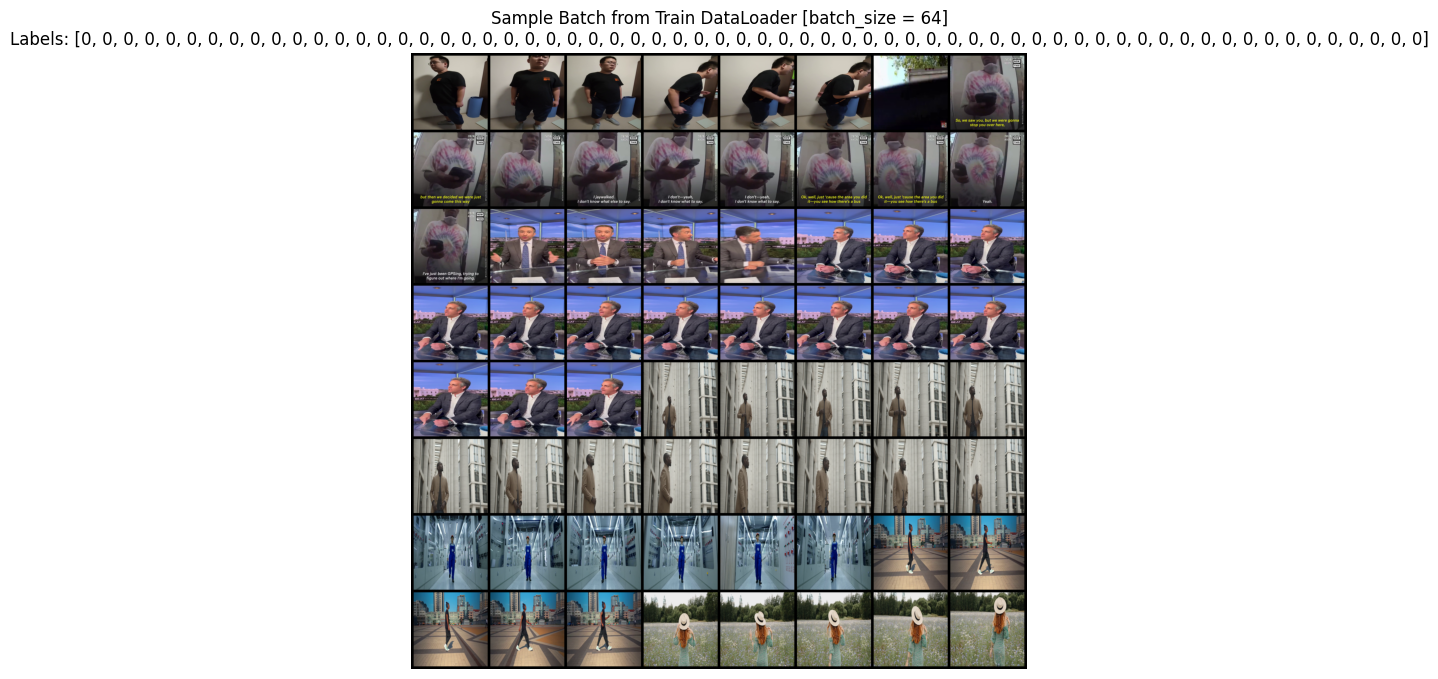

In [35]:
import matplotlib.pyplot as plt  # For visualizing images

# Get a batch of training data (see batch_size above)
images, labels = next(iter(train_dataloader))

# Make a grid from the sample batch
image_grid_sample = torchvision.utils.make_grid(
  images,
  nrow=grid_row_length,
  padding=8,
  normalize=False
)

# Move the image grid to the CPU
image_grid_sample = image_grid_sample.cpu()

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(image_grid_sample.permute(1, 2, 0))
plt.title(f"Sample Batch from Train DataLoader [batch_size = {batch_size}]\nLabels: {labels.tolist()}")
plt.axis("off")
plt.show()


# Defining the Neural Network

In [36]:
'''
Why don't I notice MASSIVE speedup compared to CPU? 
Because your network is really small.
Try increasing the width of your network 
E.g.: argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d
They need to be the same number, see what kind of speedup you get.

Calculate padding by using the formula:
padding = (kernel_size - 1) / stride
'''

import torch.nn as nn  # For neural network layers
import torch.nn.functional as F  # For other functions
import torch.autograd.profiler as profiler  # For profiling the model

class BaselineModel(nn.Module):
  def __init__(self):
    super().__init__()
    # https://pytorch.org/docs/main/nn.html#module-torch.nn
    self.seq1 = nn.Sequential(
      nn.Conv2d(3, 32, 3, 1, 1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 128, 3, 1, 1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
    )
    self.seq3 = nn.Sequential(
      nn.Conv2d(1024, 1024, 3, 1, 1, groups=1024),
      nn.Conv2d(1024, 1024, 1, 1, 0),
      nn.BatchNorm2d(1024),
      nn.ReLU(),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Dropout(0.5),
      nn.Linear(1024, 1),
      nn.ReLU(),
      nn.Linear(1, 1),
      nn.Sigmoid(),
    )

  def seq2(self, size):
    return nn.Sequential(
      nn.ReLU(),
      nn.Conv2d(size, size, 3, 1, 1, groups=size), # depthwise convolution
      nn.Conv2d(size, size, 1, 1, 0), # pointwise convolution
      nn.BatchNorm2d(size),
      nn.ReLU(),
      nn.Conv2d(size, size, 3, 1, 1, groups=size),
      nn.Conv2d(size, size, 1, 1, 0),
      nn.BatchNorm2d(size),
      nn.MaxPool2d(3, 2, 1)
    )

  def forward(self, x):
    with profiler.record_function("model_inference"):
      x = self.seq1(x)
      pba = x # set aside residual (PBA = Previous Block Activation)

      for size in [128, 256, 512, 728]:
        x = self.seq2(size)(x)
        residual = nn.Conv2d(size, size, 1, 2, 0)(pba) # project residual
        x += residual # add back residual
        pba = x # set aside next residual

      x = self.seq3(x)
      return x

# Create an instance of the model
model = BaselineModel()

# Move the model to the GPU if available, must be called before creating optimizer
model = model.to(device)

# Defining the Loss Function and Optimizer

In [37]:
import torch.optim as optim  # For optimizers

# Define the loss function
# https://pytorch.org/docs/main/nn.html#loss-functions
criterion = nn.CrossEntropyLoss().to(device)

# Define the optimizer
'''
momentum is a parameter that helps accelerate gradients vectors in the right directions, thus leading to faster converging.
'''
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training the Model

In [38]:
from tqdm import tqdm  # For nice progress bar!
'''
epoch is the number of times the model will loop through the entire dataset

i is the number of times the model will loop through the mini-batches

data is a list of [images, labels]

we zero the parameter gradients because PyTorch accumulates the gradients on
subsequent backward passes and we don't want to mix up gradients between mini-batches.

loss.backward() computes the derivative of the loss w.r.t. the parameters
using backpropagation. The loss is a function of the weights and biases of
the model that we initialized in the previous cell. The derivative is computed
for each parameter and stored in the .grad attribute of the parameter.

optimizer.step() updates the parameters using the gradients computed in the
previous step. Specifically, it subtracts a multiple of the gradient from the
parameter values. The multiple is controlled by the learning rate, which we
set to 0.001 in the previous cell.

running_loss is the sum of the losses of all the mini-batches in the current
epoch. We print the running loss every 25 mini-batches.

The loss is averaged over all examples in the mini-batch. For example, if the
batch size is 16, then the loss printed for each mini-batch is the average
loss of 16 examples in the mini-batch.
'''

for epoch in range(epochs): # loop over the dataset multiple times
  with tqdm(train_dataloader, unit="batch") as tepoch:
    running_loss = 0.0
    for i, data in enumerate(tepoch, 0):
      tepoch.set_description(f"Epoch {epoch + 1}")

      # get the images; data is a list of [images, labels]
      images, labels = data

      # Move the images to the GPU if available
      images = images.to(device)
      labels = labels.to(device)

      # zero the parameter gradients for every mini-batch
      optimizer.zero_grad()

      # make predictions
      outputs = model(images)

      # get the index of the prediction with the highest score
      predictions = torch.argmax(outputs, dim=1, keepdim=True).squeeze()

      # compute the loss
      loss = criterion(outputs, labels)

      # compute the accuracy
      correct = (predictions == labels).sum().item()
      accuracy = correct / batch_size * 100.

      # compute the gradients
      loss.backward()

      # update the learning weights
      optimizer.step()

      # update statistics
      running_loss += loss.item()
      
      tepoch.set_postfix(loss=running_loss / (i + 1), accuracy=accuracy)

      # reset running loss for every epoch
      running_loss = 0.0

print("Finished Training")


Epoch 1:   0%|          | 0/56 [00:00<?, ?batch/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument weight in method wrapper_CUDA___conv_depthwise2d)

# Saving the Trained Model

In [ ]:
# Save the model
torch.save(model.state_dict(), model_name)

# Display 4x4 Grid of Sample Train Images

In [ ]:
# Get a batch of test data (see batch_size above)
images, labels = next(iter(test_dataloader))

# Make a grid from the sample batch
image_grid_sample = torchvision.utils.make_grid(
  images,
  nrow=batch_size // 8,
  padding=8,
  normalize=False
)

# Move the image grid to the CPU
image_grid_sample = image_grid_sample.cpu()

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(image_grid_sample.permute(1, 2, 0))
plt.title(f"Sample Batch from Test DataLoader [batch_size = {batch_size}]\nLabels: {labels.tolist()}")
plt.axis("off")
plt.show()

# Testing the Model

In [ ]:
# Create an instance of the model
model = BaselineModel().to(device)

# Load the model
model.load_state_dict(torch.load(model_name))

with profiler.profile(with_stack=True, profile_memory=True) as prof:
  outputs = model(images) # add comments

_, predicted = torch.max(outputs, 1) # add comments

# Plot the grid with corresponding labels and predictions
plt.figure(figsize=(8, 8))
plt.imshow(image_grid_sample.permute(1, 2, 0))
plt.title(f"Sample Batch from Test DataLoader [batch_size = {batch_size}]\nLabels: {predicted.tolist()}")
plt.axis("off")
plt.show()

# Accuracy of the Model

In [ ]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  with tqdm(train_dataloader, unit="batch") as tepoch:
    for data in tepoch:
      images, labels = data
      
      # calculate outputs by running images through the network
      outputs = model(images)
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * correct / total}%')


# Additional Statistics

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classification_categories}
total_pred = {classname: 0 for classname in classification_categories}

# again no gradients needed
with torch.no_grad():
  with tqdm(train_dataloader, unit="batch") as tepoch:
    for data in tepoch:
      images, labels = data

      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      # collect the correct predictions for each class
      for label, prediction in zip(labels, predictions):
        if label == prediction:
          correct_pred[classification_categories[label]] += 1
        total_pred[classification_categories[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=10))

In [ ]:
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))